<a href="https://colab.research.google.com/github/essymizo/GIS_MachineLearning/blob/main/LULCprobaVsklearnRF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a quick walkthrough of the project on Land Use Land Cover Classification using PROBA V data. The idea was to utilize the global Land Cover data of 2015 generated by the Copernicus team using PROBA V data to train various classification models as a test case over Indian sites. Once the model is effectively trained, we will proceed to check it's accuracy using the test data and finally predict it with data over other years and regions. First step is to initialize and authenticate.

In [ ]:
# Import the earth engine library and authenticate with your credentials
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=r8RfvGZGPBYrPyXJD-XapOcfN61nuLI6tqRyy8yuSCM&tc=zRPVtDherQtxpMzYq7KMSg0UJ1Vz9y1IdLHAeGzic4E&cc=bfE3BaA7zL_t2TVHkAsq4uOmD_8CdqQX-uuP-6sr-nI

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AVHEtk5eIUsdNOKg44ntRer302JV4NuR5708uXoqK1ZXTJUGi8t91sWdacA

Successfully saved authorization token.


Next, I'll install some dependencies and import the libraries required.

In [ ]:
#Install and import geemap for alternative to using folium for map display and sampleRect for numpy array creation
!pip install geemap
# import geemap.eefolium as emap
import geemap
# Import GDAL, NumPy, and matplotlib
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.6 MB/s eta 0:00:00
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11135 sha256=d945351fdc68e7e8a93e2faa3bbbc56763449e3614ffc6ddc94cd

Take a look at the full data for 2015-2016 as available on the Earth Engine data catalogue.

In [ ]:
#Import the image collection of the global land use land cover for 2015
lulc2015=ee.ImageCollection('COPERNICUS/Landcover/100m/Proba-V/Global').mosaic().select('discrete_classification')

In [ ]:
print(lulc2015.getInfo())

{'type': 'Image', 'bands': [{'id': 'discrete_classification', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}]}


In [ ]:
#Reclassify the PROBA classes to classes of our interest
unclass=lulc2015.eq(0)
water=lulc2015.eq(200).Or(lulc2015.eq(80))
forest=lulc2015.gte(111).And(lulc2015.neq(200))
urban=lulc2015.eq(50)
barren=lulc2015.eq(60)
ice=lulc2015.eq(70)
other_veg=(lulc2015.gte(20).And(lulc2015.lte(40))).Or(lulc2015.eq(90))
reclass_im=water.multiply(1).add(forest.multiply(2)).add(urban.multiply(5)).add(barren.multiply(4)).add(ice.multiply(6)).add(other_veg.multiply(3)).add(unclass.multiply(0))

In [ ]:
#Define aoi over which we will run the classification
aoi=ee.Geometry.Polygon([[[91.62456970214842, 26.291270819386938],[91.62456970214842, 26.08547356351828],[91.90746765136717, 26.08547356351828],[91.90746765136717, 26.291270819386938]]])

In [ ]:
#Use geemap's Earth Engine with folium library previously imported as emap to generate a Map object and display the reclassified map
Map = geemap.Map()
Map.addLayer(reclass_im.clip(aoi), {'min': 0,'max': 7,'palette':['black','Teal','DarkGreen','Chartreuse','yellow','grey','white']}, 'Classified LULC')
Map.addLayerControl()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [ ]:
reclass_im2=reclass_im.reproject(crs= lulc2015.select('discrete_classification').projection().crs(),scale=100)

In [ ]:
# Get 2-d pixel array for AOI - returns feature with 2-D pixel array as property per band.
band_arrs = reclass_im2.sampleRectangle(region=aoi)

In [ ]:
lulc_np=np.array(band_arrs.get('discrete_classification').getInfo())

In [ ]:
lulc_np.shape

(230, 315)

In [ ]:
lulc_np.max()

5

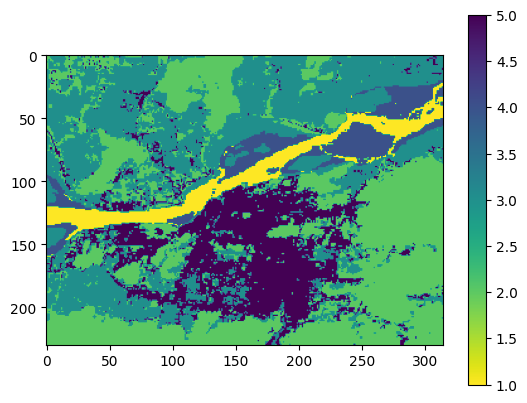

In [ ]:
#Display the reclassified numpy image using matplotlib
# Plotting in greyscale
plt.imshow(lulc_np[:,:],cmap=plt.cm.viridis_r)
plt.colorbar()

In [ ]:
#Function to mask clouds
def mask_Proba_clouds(image):
  qa = image.select('SM')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  bit_mask_0 = 1 << 0 #<< is a bitwise shift. x<<y is equivalent to x multiplied by 2^y and x>>y is x divided by 2^y
  bit_mask_1 = 1 << 1
  bit_mask_2 = 1 << 2

  # Both flags should be set to zero, indicating clear conditions.
  mask = qa.bitwiseAnd(bit_mask_0).eq(0).Or(qa.bitwiseAnd(bit_mask_1).eq(0)).Or(qa.bitwiseAnd(bit_mask_2).eq(0))

  swir=image.select('SWIR')
  mask=mask.And(swir.lt(700))

  # Return the masked and scaled data, without the QA bands.
  return image.updateMask(mask).select(['RED','NIR','BLUE','SWIR','NDVI','SM'])

In [ ]:
im_col=ee.ImageCollection("VITO/PROBAV/C1/S1_TOC_100M").filterBounds(aoi)

premon_im=im_col.filterDate(ee.Date('2015-01-01'),ee.Date('2015-04-30')).map(mask_Proba_clouds).sort('CLOUD_COVER_PERCENTAGE',False).mosaic()
#mon_im=im_col.filterDate(ee.Date('2015-05-01'),ee.Date('2015-08-31')).map(mask_Proba_clouds).sort('CLOUD_COVER_PERCENTAGE',False).mosaic()
#postmon_im=im_col.filterDate(ee.Date('2015-09-01'),ee.Date('2015-12-31')).map(mask_Proba_clouds).sort('CLOUD_COVER_PERCENTAGE',False).mosaic()

In [ ]:
Map = geemap.Map()
Map.addLayer(premon_im.clip(aoi), {'min': 0,'max': 1000,'bands':['NIR','RED','BLUE']}, 'Classified LULC pre')
Map.addLayerControl()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [ ]:
premon_im=premon_im.reproject(crs= premon_im.select('RED').projection().crs(),scale=100)

In [ ]:
# Get 2-d pixel array for AOI - returns feature with 2-D pixel array as property per band.
premon_np = geemap.ee_to_numpy(ee_object=premon_im,region=aoi)

In [ ]:
premon_np.shape

(230, 315, 6)

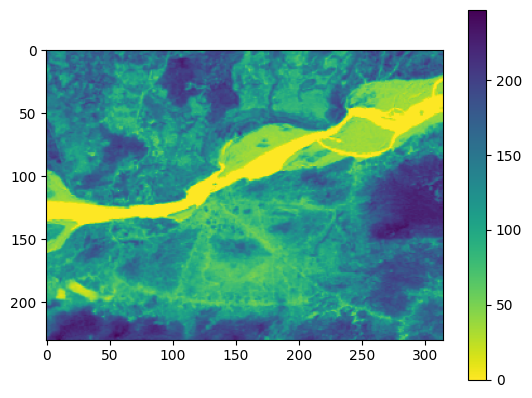

In [ ]:
#Display the reclassified numpy image using matplotlib
# Plotting in greyscale
plt.imshow(premon_np[:,:,4],cmap=plt.cm.viridis_r)
plt.colorbar()

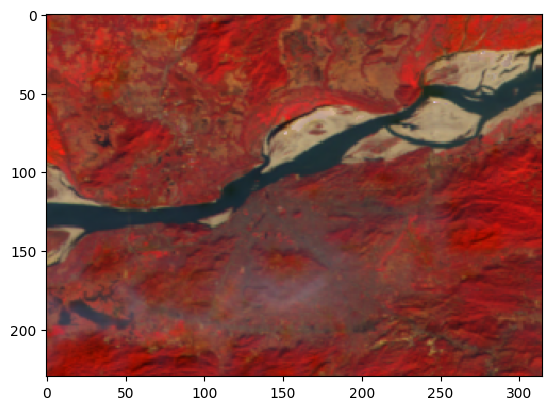

In [ ]:
colorComb=np.array([1,0,2]) #Order determined by the order in the select() in the cloud masking and return
FCCim=premon_np[:,:,colorComb]
maxVal=max(premon_np[:,:,2].max(),premon_np[:,:,1].max(),premon_np[:,:,0].max())
minVal=min(premon_np[:,:,2].min(),premon_np[:,:,1].min(),premon_np[:,:,0].min())
FCCim=FCCim/(maxVal-minVal)
plt.imshow(FCCim)

In [ ]:
# Importing the classification algorithm and a module to split dataset into training and testing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(premon_np[:,:,:], lulc_np[:,:], test_size = 0.3, random_state = 42)

In [ ]:
test_features.shape

(69, 315, 6)

In [ ]:
train_labels.shape

(161, 315)

In [ ]:
# The image needs to be reshaped into an array
new_shape = (train_features.shape[0] * train_features.shape[1], train_features.shape[2])

train_features_array = train_features.reshape(new_shape)
train_label_array=train_labels.reshape(train_labels.shape[0]*train_labels.shape[1])
print('New Training Features Shape:', train_features_array.shape)
print('New Training Labels Shape:', train_label_array.shape)

New Training Features Shape: (50715, 6)
New Training Labels Shape: (50715,)


In [ ]:
# Initialize our model with 200 trees
rf = RandomForestClassifier(n_estimators=200, oob_score=True)

In [ ]:
rf_train=rf.fit(train_features_array,train_label_array)

In [ ]:
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))
bands = range(1,13)

for b, imp in zip(bands, rf.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

Our OOB prediction of accuracy is: 82.09997042295178%
Band 1 importance: 0.23841715897883967
Band 2 importance: 0.16869650663436744
Band 3 importance: 0.1631102041174173
Band 4 importance: 0.1873609596623537
Band 5 importance: 0.21631857277594163
Band 6 importance: 0.026096597831080225


In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
all_accuracies = cross_val_score(estimator=rf, X=train_features_array, y=train_label_array, cv=5)

In [ ]:
print(all_accuracies.mean())

0.7974366558217489


In [ ]:
print(all_accuracies.std())

0.007922773036180041


In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
rf_GS = RandomForestClassifier()
grid_param = {'n_estimators': [1,5,10,20,30,40,50,100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
}

In [ ]:
gd_sr = GridSearchCV(estimator=rf_GS,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [ ]:
gd_sr.fit(train_features_array, train_label_array)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
gd_sr.best_params_

{'n_estimators': 1000}

In [ ]:
gd_sr.best_score_

0.7988957902001379

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(gd_sr.cv_results_)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.094409,0.007516,0.006754,0.001503,1,{'n_estimators': 1},0.735581,0.737356,0.718032,0.730356,0.722370,0.728739,0.007468,17
1,0.422986,0.004037,0.016347,0.000211,5,{'n_estimators': 5},0.785369,0.783003,0.768806,0.780735,0.761905,0.775964,0.009052,16
2,0.823474,0.007916,0.030152,0.000211,10,{'n_estimators': 10},0.797792,0.784876,0.776496,0.790496,0.775116,0.784955,0.008531,15
3,1.646274,0.017180,0.059159,0.002283,20,{'n_estimators': 20},0.802425,0.791580,0.784580,0.790792,0.780735,0.790023,0.007385,14
4,2.446668,0.032573,0.085268,0.001618,30,{'n_estimators': 30},0.807453,0.795623,0.788228,0.791186,0.785961,0.793690,0.007603,13
5,3.275416,0.045789,0.112421,0.001553,40,{'n_estimators': 40},0.807946,0.797496,0.789411,0.794735,0.785271,0.794972,0.007743,11
6,4.111261,0.023530,0.139297,0.000659,50,{'n_estimators': 50},0.808144,0.796608,0.789609,0.793059,0.781130,0.793710,0.008857,12
7,8.234700,0.045841,0.277392,0.001392,100,{'n_estimators': 100},0.809524,0.801834,0.794242,0.793256,0.785961,0.796963,0.008046,10
8,16.468673,0.106582,0.555775,0.006324,200,{'n_estimators': 200},0.811298,0.800848,0.793947,0.794735,0.787341,0.797634,0.008062,9
9,24.840814,0.165192,0.833452,0.009392,300,{'n_estimators': 300},0.810214,0.802228,0.794637,0.794538,0.787341,0.797792,0.007794,7


In [ ]:
df[['param_n_estimators','mean_test_score','std_test_score']]

,param_n_estimators,mean_test_score,std_test_score
0,1,0.728739,0.007468
1,5,0.775964,0.009052
2,10,0.784955,0.008531
3,20,0.790023,0.007385
4,30,0.793690,0.007603
5,40,0.794972,0.007743
6,50,0.793710,0.008857
7,100,0.796963,0.008046
8,200,0.797634,0.008062
9,300,0.797792,0.007794


In [ ]:
RandomForestClassifier()

# Plotting

In [ ]:
n_iter=np.array(df.param_n_estimators)
mean_test=np.array(df.mean_test_score)
std_test=np.array(df.std_test_score)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   mean_fit_time       17 non-null     float64
 1   std_fit_time        17 non-null     float64
 2   mean_score_time     17 non-null     float64
 3   std_score_time      17 non-null     float64
 4   param_n_estimators  17 non-null     object 
 5   params              17 non-null     object 
 6   split0_test_score   17 non-null     float64
 7   split1_test_score   17 non-null     float64
 8   split2_test_score   17 non-null     float64
 9   split3_test_score   17 non-null     float64
 10  split4_test_score   17 non-null     float64
 11  mean_test_score     17 non-null     float64
 12  std_test_score      17 non-null     float64
 13  rank_test_score     17 non-null     int32  
dtypes: float64(11), int32(1), object(2)
memory usage: 1.9+ KB


In [ ]:
df_numeric=df.apply(pd.to_numeric,errors='ignore')

In [ ]:
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   mean_fit_time       17 non-null     float64
 1   std_fit_time        17 non-null     float64
 2   mean_score_time     17 non-null     float64
 3   std_score_time      17 non-null     float64
 4   param_n_estimators  17 non-null     int64  
 5   params              17 non-null     object 
 6   split0_test_score   17 non-null     float64
 7   split1_test_score   17 non-null     float64
 8   split2_test_score   17 non-null     float64
 9   split3_test_score   17 non-null     float64
 10  split4_test_score   17 non-null     float64
 11  mean_test_score     17 non-null     float64
 12  std_test_score      17 non-null     float64
 13  rank_test_score     17 non-null     int32  
dtypes: float64(11), int32(1), int64(1), object(1)
memory usage: 1.9+ KB


In [ ]:
n_iter=df_numeric.param_n_estimators
mean_test=df_numeric.mean_test_score
std_test=df_numeric.std_test_score

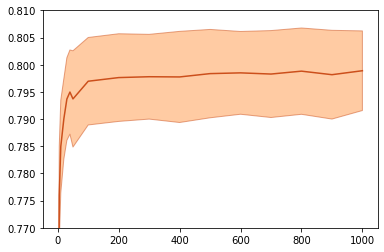

In [ ]:
plt.plot(n_iter, mean_test, 'k', color='#CC4F1B')
plt.ylim(0.77,0.81)
plt.fill_between(n_iter, mean_test-std_test, mean_test+std_test,alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')